# Figure : Variance Plots and Elbow Plots

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
# plot styles/formatting
import seaborn as sns

from IPython.display import Image, display
from sklearn.metrics import silhouette_score, silhouette_samples
# Path to modules
sys.path.append('../modules')
# Import my modules
from eofs import *
from kmeans import *
from utils import check_mkdir

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set default font for all plots
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


### Calculate Explained Variance

In [4]:
ceofid = 'IVT'
ssn = 'djfmam'
ssn_lst = [ssn]
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

read_path = path_to_out + ceofid + '/' + ssn + '/'
out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'
# make directories if paths do not exist
check_mkdir(out_path)
check_mkdir(fig_path)

In [5]:
err_lst = []
neofs_lst = []
pctvar_lst = []
n_events = [205., 237.]

for k, ssn in enumerate(ssn_lst):   
    ## Eigenvalues
    filepath =  read_path + 'eigenvalues_tcor.txt'
    df = pd.read_csv(filepath, header=None, names=['evals'])
    evals = df.evals.values
    # Calculate the percent explained var by each eigenvector
    pctvar = pct_variance(evals)
    # Number of EOFs that explain more than 1% of the total variance
    idx = pctvar[pctvar >= 1.0]
    neof = len(idx)

    # North Test
    total_events = n_events[k]
    err = north_test(evals, total_events)
    
    err_lst.append(err)
    neofs_lst.append(neof)
    pctvar_lst.append(pctvar)
    

### Calculate Elbow & Silhouette Scores

In [6]:
# Loadings & AR CAT
kclusters_lst = []
cohesion_lst = []
silhouette_lst = []
lower_lst = []
upper_lst = []

for i, ssn in enumerate(ssn_lst):
    filename = read_path + 'loadings_tcor.csv'
    df = pd.read_csv(filename)
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    df = df.drop(columns=['date'])
    xdata = df.values
    
    # Determine optimal K
    # maximum number of clusters (number of iterations)
    kmax =15
    kclusters, cohesion, silhouette, lower, upper = plot_optimal_k(xdata, neofs, kmax, create_plot=False)
    kclusters_lst.append(kclusters)
    cohesion_lst.append(cohesion)
    silhouette_lst.append(silhouette)
    lower_lst.append(lower)
    upper_lst.append(upper)

### Load EOF values for KDE plots

In [7]:
# Loadings & AR CAT
df_lst = []
for i, ssn in enumerate(ssn_lst):
    df = pd.read_csv(out_path + 'AR-types-loadings.csv')
    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date', 'EOF1': 'PC1', 'EOF2': 'PC2'})
#     df = df.set_index(pd.to_datetime(df.date))
    df = df.drop(columns=['date'])
    df_lst.append(df)
    
df_lst[0].head()

,PC1,PC2,AR_CAT
0,0.219751,0.086614,2
1,0.012470,-0.269401,1
2,0.405462,0.050908,2
3,0.007582,-0.171526,1
4,0.131194,-0.214660,1


### Load Centroids

In [8]:
centroids = pd.read_csv(out_path + 'centroids.txt')
centroids

,# AR_TYPE,EOF1,EOF2
0,1.0,0.115017,-0.311103
1,2.0,0.299871,0.175888
2,3.0,-0.214321,0.055363


### Create Plot

In [9]:
color_array = np.array(([122/256, 141/256, 57/256, 1], # green
                       [239/256, 86/256, 69/256, 1],  # coral
                       [254/256, 188/256, 17/256, 1]))  # gold
newcmap = ListedColormap(color_array)

# # Set custom color palette
# colors = ["#003660"]
# sns.set_palette(sns.color_palette(colors))

/home/nash/DATA/repositories/AR_types/figs/IVT/djfmam/neof2/k3/fig4_variance_elbow_kde.png


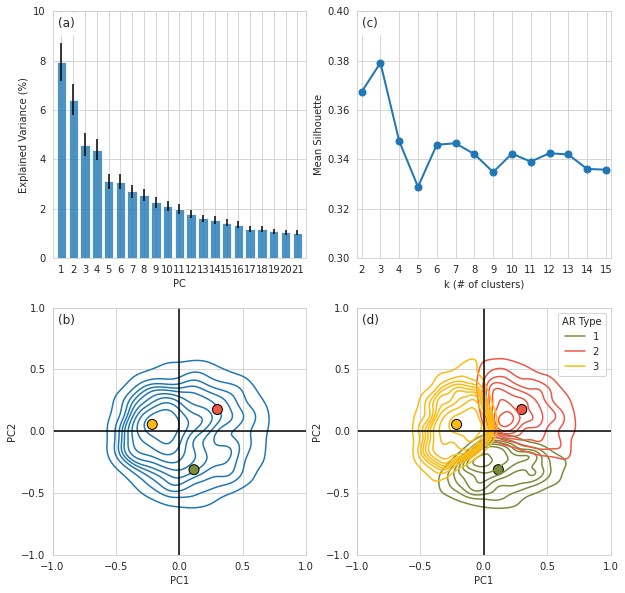

<Figure size 720x720 with 0 Axes>

In [15]:
# Create figure
fig = plt.figure(figsize=(10,10))
fname = fig_path + 'fig4_variance_elbow_kde'
fmt = 'png'
nrows = 2
ncols = 2
nplots=nrows*ncols
cent_cat = [0, 1, 2]

sns.set_style("whitegrid")

# Variance Plots
k=0
ax = fig.add_subplot(nrows, ncols, 1)
neofs = neofs_lst[k]
pctvar = pctvar_lst[k]
err = err_lst[k]
# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('PC')
ax.set_xticks(xvals)
ax.set_xlim(1.-0.75, neofs+0.75)

# y-axis
ax.set_ylabel('Explained Variance (%)')
ax.set_yticks(np.arange(0, 12, 2))
# Subtitles
xpt = 5
ypt = 231
ax.annotate('(a)', (xpt, ypt), xycoords='axes points', fontsize=12.,
            backgroundcolor='white', zorder=100)
# ax.set_title('(a)', loc='left')

# Elbow Plots TO DO: switch to silhouette scores

ax = fig.add_subplot(nrows, ncols, 2)
kclusters = kclusters_lst[k]
# coh = cohesion_lst[k][0]
# ax.plot(kclusters, coh, marker='o', linewidth=2.0, markersize=7.0, color='tab:blue')
# ax.set_ylabel('Sum of Sq Dist (cohesion)')
# ax.set_xlabel('k (# of clusters)')
# ax.set_xticks(kclusters)
# #     ax.set_yticks(np.arange(0, 110, 20))
# ax.set_xlim(1., kmax+1)
# ax.set_ylim(0, 110)
# ax.set_xticks(kclusters)
ax.annotate('(c)', (xpt, ypt), xycoords='axes points', fontsize=12.,
            backgroundcolor='white', zorder=100)
# ax.set_title('(c)', loc='left')

# ax2 = ax.twinx()
sil = silhouette_lst[k][0]
lower = lower_lst[k][0]
upper = upper_lst[k][0]
ax.plot(kclusters, sil, c='tab:blue', marker='o', linewidth=2.0, markersize=7.0)
# ax.fill_between(kclusters, lower, upper, fc='tab:blue', ec=None, alpha=0.2)
ax.set_ylabel('Mean Silhouette')
ax.set_xlabel('k (# of clusters)')
ax.set_xlim(1.75, kmax+0.25)
ax.set_ylim(0.3, 0.4)
ax.set_xticks(kclusters)

## KDE Plots with centroid points
# Set custom color palette
levs = 10
ax = fig.add_subplot(nrows, ncols, 3)
df = df_lst[k]
g = sns.kdeplot(data=df, x="PC1", y="PC2", fill=False, ax = ax, color='tab:blue')
ct = ax.scatter(centroids[' EOF1'], centroids[' EOF2'], s=100, c=cent_cat, cmap=newcmap, edgecolors='black', zorder=100)
ax.set_xticks(np.arange(-1.0, 1.5, 0.5))
ax.set_yticks(np.arange(-1.0, 1.5, 0.5))
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.annotate('(b)', (xpt, ypt), xycoords='axes points', fontsize=12.,
            backgroundcolor='white', zorder=100)
# ax.set_title('(b)', loc='left')

ax = fig.add_subplot(nrows, ncols, 4)
df = df.rename(columns={"AR_CAT": "AR Type"})
g = sns.kdeplot(data=df, x="PC1", y="PC2", hue="AR Type",  fill=False, ax = ax, palette=newcmap)
ct = ax.scatter(centroids[' EOF1'], centroids[' EOF2'], s=100, c=cent_cat, cmap=newcmap, edgecolors='black')
ax.set_xticks(np.arange(-1.0, 1.5, 0.5))
ax.set_yticks(np.arange(-1.0, 1.5, 0.5))
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.annotate('(d)', (xpt, ypt), xycoords='axes points', fontsize=12.,
            backgroundcolor='white', zorder=100)
# ax.set_title('(d)', loc='left')

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))